# Cross-correlation for magnetic data

**This notebook shows the use of the cross-correlation coefficient techniqe for magnetic data. This technique was used by several research groups$^*$ in order to estimate the magnetization direction and another signals that also depend on this vector, although not very changeable or influential by this vector.**

**The simple cross-correlation coeficient is given by:**
# $$ C = \dfrac{\sum(F - \bar{F})(G - \bar{G})}
{\sqrt{\sum(F - \bar{F})^2 \sum(G - \bar{G})^2}} $$ 
**where $F$ and $G$ represent the two magnetic data, firs derivative and horizontal gradient, for example; and $\bar{F}$ and $\bar{G}$ represent the mean for the two data sets.**

### *Some researches: 
* Fedi, M., Florio, G., & Rapolla, A. (1994). A method to estimate the total magnetization direction from a distortion analysis of magnetic anomalies. Geophysical Prospecting, 42(3), 261-274. Doi: [10.1111/j.1365-2478.1994.tb00209.x/abstract](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2478.1994.tb00209.x/abstract)

* Dannemiller, N., & Li, Y. (2006). A new method for determination of magnetization direction. Geophysics, 71(6), L69-L73. Doi: [10.1190/1.2356116](http://library.seg.org/Doi/10.1190/1.2356116)

* Gerovska, D., Araúzo‐Bravo, M. J., & Stavrev, P. (2009). Estimating the magnetization direction of sources from southeast Bulgaria through correlation between reduced‐to‐the‐pole and total magnitude anomalies. Geophysical Prospecting, 57(4), 491-505. Doi: [10.1111/j.1365-2478.2008.00761.x](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2478.2008.00761.x/full)

In [1]:
# Importing all usefull libraries for this notebook
import numpy as np
import matplotlib.pyplot as plt

### Simple example for the cross correlation coeffiecient

In [2]:
# Defines number of points
n = 200
# Define the three vectors along all directions
x = np.linspace(-1000, 1000, n)
y = x
z = -10.
# Creates the grid
X, Y = np.meshgrid(x, y)

In [3]:
# Define the elements of the prims for gravity and magnetic computation
modelgrav = (-400., 400., -400., 400., 100., 500., 2300)
modelmag = (-400., 400., -400., 400., 100., 500., 2.300)

### Computing: (i) gravity anomaly; (ii) total field anomaly; (iii) total field anomaly in magnetic pole; and (iv) reduction to pole.

In [4]:
from codes.prism import prism_gz, prism_tf

In [5]:
# Computes the potential data
gz = prism_gz(X, Y, z, modelgrav)
tf = prism_tf(X, Y, z, modelmag, (35., 22.), (66., 30))
tf_pole = prism_tf(X, Y, z, modelmag, (90., 0.), (90., 0.))

In [6]:
from codes.filtering import reduction

In [7]:
# Compute the true reduction to pole by using Fourier domain
rtp_calc = reduction(X, Y, tf, (66., 30.), (35., 22.), (90., 0.), (90., 0.))

codes/auxiliars.py:184: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


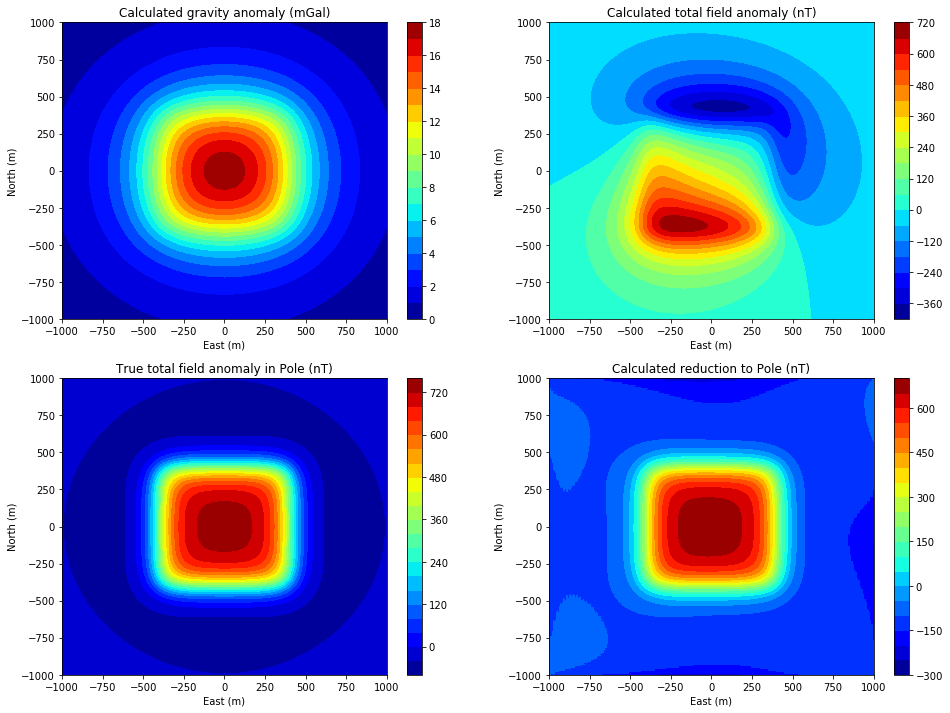

In [8]:
# Plotting the result
plt.close('all')
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.contourf(X, Y, gz, 20, cmap = plt.cm.jet)
plt.title('Calculated gravity anomaly (mGal)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(Y, X, tf, 20, cmap = plt.cm.jet)
plt.title('Calculated total field anomaly (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.contourf(Y, X, tf_pole, 20, cmap = plt.cm.jet)
plt.title('True total field anomaly in Pole (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(Y, X, rtp_calc, 20, cmap = plt.cm.jet)
plt.title('Calculated reduction to Pole (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.savefig('figures/correlation01-data.png')

plt.show()

### Computing the correlation coefficient by using a grid for inclination and declination values

In [9]:
from codes.derivative import totalgrad
from codes.filtering import pseudograv, tilt

In [20]:
# Create the intervals for inclination and declination
inc = np.arange(20., 81., 1.)
dec = np.arange(-60., 60., 1.)

ni, nd = inc.size, dec.size
# Create the grid
Dec, Inc = np.meshgrid(dec, inc)

In [21]:
# Create the array to allocate the result
res1 = np.zeros([ni, nd])
res2 = np.zeros([ni, nd])
res3 = np.zeros([ni, nd])

In [12]:
from codes.statistical import cccoef

In [22]:
# Computing all result
for j in range(nd):
    for i in range(ni):
        rtp = reduction(x, y, tf, (66., 30.), (inc[i], dec[j]), (90., 0.), (90., 0.))
        pgrav = pseudograv(x, y, rtp, (66., 30), (inc[i], dec[j]), 2300., 2.3)
        tga = totalgrad(x, y, rtp)
        ta = tilt(x, y, rtp)        
        # Cross-correlation between reduction to pole and total gradient
        # Cross-correlation between reduction to pole and tilt angle
        # Cross-correlation between reduction to pole and pseudogravity
        res1[i,j] = cccoef(rtp, tga)
        res2[i,j] = cccoef(rtp, ta)
        res3[i,j] = cccoef(rtp, pgrav)

In [23]:
from codes.statistical import analysis

In [25]:
print 'Reduction to Pole and Total gradient'
_ = analysis(res1)
print
print 'Reduction to Pole and Tilt angle'
_ = analysis(res2)
print
print 'Reduction to Pole and Pseudogravity'
_ = analysis(res3)

Reduction to Pole and Total gradient
Minimum:    0.2631
Maximum:    0.5984
Mean value: 0.4779
Variation:  0.3354

Reduction to Pole and Tilt angle
Minimum:    0.7007
Maximum:    0.8061
Mean value: 0.7509
Variation:  0.1053

Reduction to Pole and Pseudogravity
Minimum:    0.3867
Maximum:    0.9036
Mean value: 0.7010
Variation:  0.5169


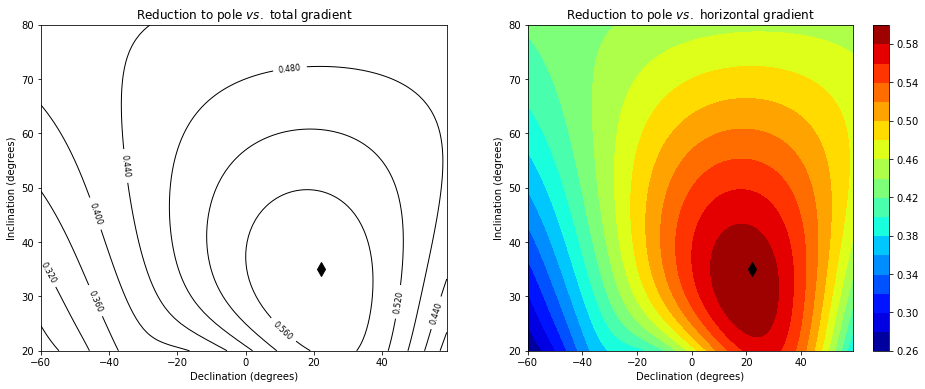

In [30]:
# Plotting the first result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot1 = plt.contour(Dec, Inc, res1, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.plot(22., 35., 'kd', markersize = 10)
plt.clabel(plot1, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ total gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res1, 20, cmap = plt.cm.jet)
plt.plot(22., 35., 'kd', markersize = 10)
plt.title('Reduction to pole $vs.$ horizontal gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.savefig('figures/correlation02-rtp-vs-horizontal.png')
plt.show()

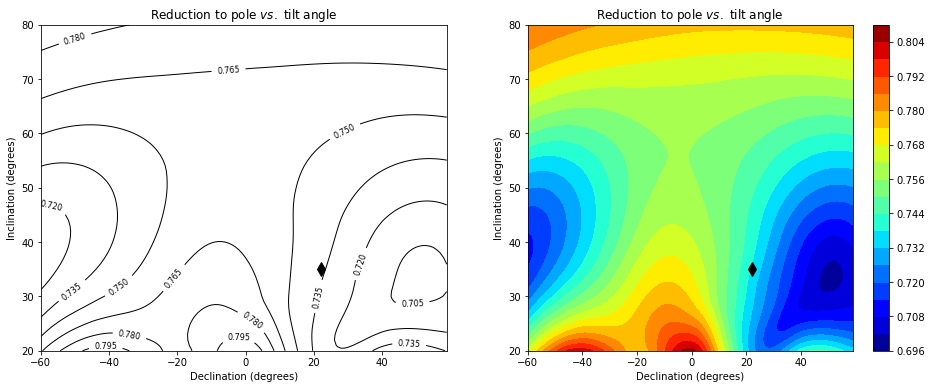

In [31]:
# Plotting the second result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot2 = plt.contour(Dec, Inc, res2, 8, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.plot(22., 35., 'kd', markersize = 10)
plt.clabel(plot2, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ tilt angle')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res2, 20, cmap = plt.cm.jet)
plt.plot(22., 35., 'kd', markersize = 10)
plt.title('Reduction to pole $vs.$ tilt angle')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.savefig('figures/correlation03-rtp-vs-tilt.png')
plt.show()

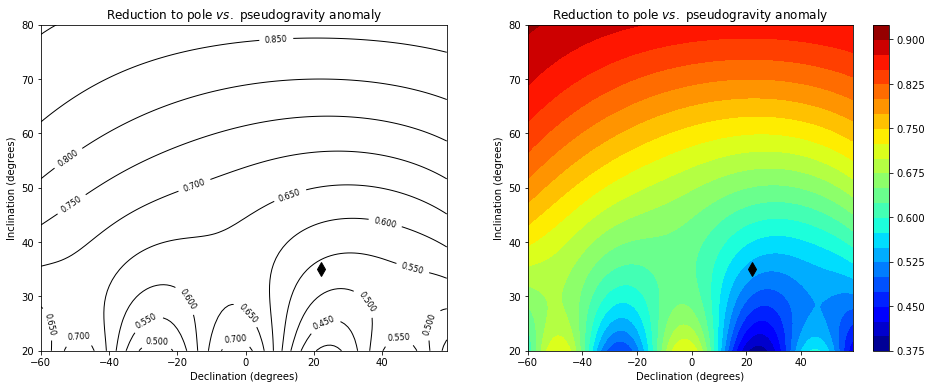

In [32]:
# Plotting the third result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot3 = plt.contour(Dec, Inc, res3, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.plot(22., 35., 'kd', markersize = 10)
plt.clabel(plot3, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ pseudogravity anomaly')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res3, 20, cmap = plt.cm.jet)
plt.plot(22., 35., 'kd', markersize = 10)
plt.title('Reduction to pole $vs.$ pseudogravity anomaly')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.savefig('figures/correlation04-rtp-vs-pseudograv.png')
plt.show()